In [1]:
from interaction_inference import dataset, optimization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

# Prior for interaction: miRNA targets

miRNA are small non-coding RNA that play an important role in regulating expression by 'splitting' / degrading mRNA transcripts.

TargetScan is a database that predicts the mRNA targeted by a given miRNA (albeit with many false positives).

This can be used both as a prior to select candidates for interaction testing, or as validation data to assess results of interaction tests. 

## Select miRNA

From the Smart-seq-total dataset of transcript counts, select miRNA transcripts

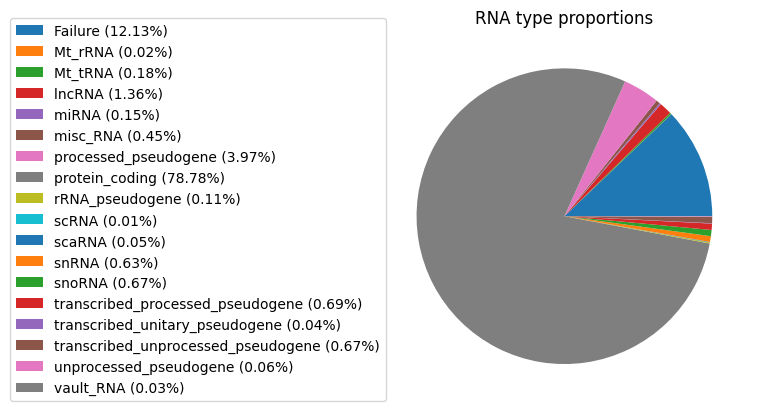

18 miRNA


,Fibroblasts_A10_S10,Fibroblasts_A11_S11,Fibroblasts_A2_S2,Fibroblasts_A3_S3,Fibroblasts_A4_S4,Fibroblasts_A5_S5,Fibroblasts_A7_S7,Fibroblasts_A8_S8,Fibroblasts_B10_S34,Fibroblasts_B11_S35,...,Fibroblasts_P18_S378,Fibroblasts_P1_S361,Fibroblasts_P21_S381,Fibroblasts_P22_S382,Fibroblasts_P23_S383,Fibroblasts_P3_S363,Fibroblasts_P4_S364,Fibroblasts_P5_S365,Fibroblasts_P6_S366,Fibroblasts_P8_S368
MIR100,0,5,0,0,1,0,0,0,0,2,...,3,0,4,2,105,0,0,0,0,0
MIR103A2,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,62
MIR16-2,0,0,0,0,0,0,0,0,0,0,...,66,0,10,3,39,0,29,0,0,0
MIR199A1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,3,0,0,0,0,0,0
MIR199A2,1,0,1,0,0,1,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
MIR221,19,0,0,0,13,0,0,0,0,0,...,0,0,0,0,51,0,2,0,0,0
MIR222,37,16,1,7,18,3,1,25,15,19,...,44,5,39,8,43,1,3,2,6,2
MIR23A,0,7,0,0,2,0,0,4,0,1,...,10,0,6,0,437,0,1,0,3,1
MIR24-2,0,2,0,0,0,0,0,0,2,0,...,3,0,12,12,28,0,0,1,1,0
MIR27A,0,5,0,0,6,2,6,10,3,1,...,0,0,1,0,0,0,0,0,1,0


In [87]:
# read fibroblast transcript counts (for genes with mean expression > 1)
data_FIB = pd.read_csv("../Datasets/GSE151334_FIB_counts_thresh.csv", index_col=0)

# read RNA types in from file
biotypes_dict = json.load(open("../Datasets/GSE151334_RNA_types_thresh.json"))
biotypes_dict = {int(i): btype for i, btype in biotypes_dict.items()}
biotypes = [btype for btype in biotypes_dict.values()]

# display proportions of RNA types
counts = np.unique(biotypes, return_counts=True)
plt.pie(counts[1])
plt.legend(loc=(-1, 0), labels=[f"{name} ({round(100 * count / data_FIB.shape[0], 2)}%)" for name, count in zip(counts[0], counts[1])])
plt.title("RNA type proportions")
plt.show()

# select indices of types
pcRNA_indices = [idx for idx, val in enumerate(biotypes) if val == "protein_coding"]
miRNA_indices = [idx for idx, val in enumerate(biotypes) if val == "miRNA"]

# select rows by index
data_pcRNA = data_FIB.iloc[pcRNA_indices]
data_miRNA = data_FIB.iloc[miRNA_indices]

print(f"{data_miRNA.shape[0]} miRNA")

data_miRNA

## Analysis code

In [27]:
def estimate_capture(df, beta_mean=0.1):

    # set mean beta
    MeanBETA = beta_mean

    #xx<-Matrix::colSums(Data)
    xx = df.sum(axis='rows')

    #Normcount <- t_sp(t_sp(Data)/xx) * mean(xx)
    # Normcount <- Matrix::t(Matrix::t(Data)/xx) * mean(xx)
    Normcount = (df / xx) * np.mean(xx) # sum = mean(xx) per column

    #means <- Matrix::rowMeans(Normcount)
    means = Normcount.mean(axis='columns')

    #lmeans <- log(means)
    lmean = np.log(means)

    #med <- apply(log(Normcount + 1), 1, function(x) {
    #    median(x)
    #})
    med = np.log(Normcount + 1).median(axis=1)

    #mad <- apply(log(Normcount + 1), 1, function(x) {
    #    mad(x)
    #})
    mad = np.log(Normcount + 1).apply(lambda row: (row - row.median()).abs().median(), axis=1)

    #bound <- med + 3 * mad
    bound = med + 3*mad

    #maxlogGene <- apply(log(Normcount + 1), 1, max)
    maxlogGene = np.log(Normcount + 1).max(axis=1)

    #ind <- which(maxlogGene < bound)
    ind = maxlogGene < bound

    #dropout = apply(Data, 1, function(x) {
    #    length(which(x == 0))/length(x)
    #})
    dropout = df.apply(lambda row: (row == 0).sum() / row.size, axis=1)


    #Select_ind <- intersect(ind, which(dropout < 0.35))
    Select_ind = ind & (dropout < 0.35)

    # Selected_genes <- rownames(Data)[Select_ind]
    Selected_genes = list(Select_ind.index)

    #temppp <- Matrix::colSums(Data[Select_ind, ])
    temppp = df[Select_ind].sum(axis=0)

    #BETA <- temppp/mean(temppp) * MeanBETA
    BETA = (temppp / temppp.mean()) * MeanBETA

    #if (length(which(BETA >= 1)) > 0) {
    #    BETA[BETA >= 1] = max(BETA[BETA < 1])
    #}
    #if (length(which(BETA <= 0)) > 0) {
    #    BETA[BETA <= 0] = min(BETA[BETA > 0])
    #}
    if (BETA >= 1).size > 0:
        BETA[BETA >= 1] = BETA[BETA < 1].max()
    if (BETA <= 0).size > 0:
        BETA[BETA <= 0] = BETA[BETA > 0].min()

    #names(BETA) <- colnames(Data)

    #return(list(BETA = BETA, Selected_genes = Selected_genes))
    BETA = BETA.to_numpy()
    
    return BETA

In [28]:
def construct_dataset(name, mir_sample, target_samples, beta, thresh_OB=5, resamples=1000):

    # size
    gene_pairs, cells = target_samples.shape

    # construct paired count dataframe
    counts_df = pd.DataFrame(
        index = [f"Gene-pair-{i}" for i in range(gene_pairs)],
        columns = [f"Cell-{j}" for j in range(cells)]
    )

    # fill with pairs
    for i in range(gene_pairs):
        gene_i = mir_sample
        gene_j = target_samples.iloc[i]
        gene_pair_ij = list(zip(gene_i, gene_j))
        counts_df.iloc[i] = gene_pair_ij

    # construct dataset object
    data = dataset.Dataset(name)
    data.count_dataset = counts_df
    data.cells = cells
    data.gene_pairs = gene_pairs

    # settings
    data.thresh_OB = thresh_OB
    data.threshM_OB = thresh_OB
    data.resamples = resamples

    # set capture
    data.beta = beta

    return data

In [29]:
beta = estimate_capture(data_FIB)

## Select miRNA targets

For an miRNA in the above table, use TargetScan to get a list of the predicted mRNA targets 

4485 miRNA targets predicted
2807 are in the dataset


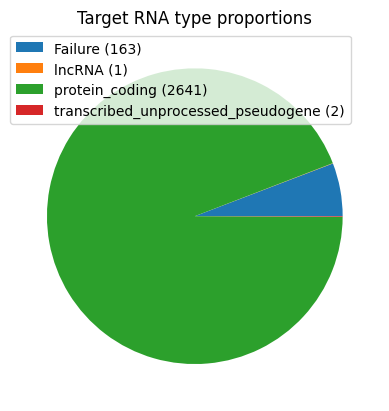

,Representative transcript,Gene name,3P-seq tags + 5,Total sites,8mer sites,7mer-m8 sites,7mer-A1 sites,6mer sites,Representative miRNA,Predicted occupancy (low miRNA),Predicted occupancy (high miRNA),Predicted occupancy (transfected miRNA),Cumulative weighted context++ score,Total context++ score,Aggregate PCT
Target gene,,,,,,,,,,,,,,,
CADM2,ENST00000383699.3,cell adhesion molecule 2,5,8,4,2,2,4,hsa-miR-16-2-3p,NaN,NaN,NaN,-1.11,-1.11,NaN
FUT9,ENST00000302103.5,"fucosyltransferase 9 (alpha (1,3) fucosyltrans...",5,3,0,1,2,1,hsa-miR-16-2-3p,NaN,NaN,NaN,-0.92,-0.92,NaN
BCHE,ENST00000264381.3,butyrylcholinesterase,5,2,2,0,0,0,hsa-miR-16-2-3p,NaN,NaN,NaN,-0.79,-0.79,NaN
AL353791.1,ENST00000426179.1,NaN,5,4,2,0,2,0,hsa-miR-16-2-3p,NaN,NaN,NaN,-0.78,-0.78,NaN
RGS17,ENST00000367225.2,regulator of G-protein signaling 17,11,3,2,0,1,4,hsa-miR-16-2-3p,NaN,NaN,NaN,-0.76,-1.55,NaN


In [153]:
# set miRNA
mir = 2

# load predicted targets
target_df = pd.read_csv("TargetScan8.0__miR-16-2-3p_195-3p.Human.predicted_targets.txt", delimiter="\t", index_col=0)

# display statistics
target_names = list(target_df.index)
gene_names = list(data_FIB.index)
shared_names = list(set(target_names) & set(gene_names))

print(f"{len(target_names)} miRNA targets predicted")
print(f"{len(shared_names)} are in the dataset")

# target biotypes
target_biotypes = []
for i, btype in biotypes_dict.items():
    if gene_names[i] in target_names:
        target_biotypes.append(btype)

# display proportions of RNA types
counts = np.unique(target_biotypes, return_counts=True)
plt.pie(counts[1])
plt.legend(loc=(0,0.75), labels=[f"{name} ({count})" for name, count in zip(counts[0], counts[1])])
plt.title("Target RNA type proportions")
plt.show()

target_df.head()

In [154]:
# construct dataset of the miRNA paired with all other samples
dataset_mir = construct_dataset("test", data_miRNA.iloc[mir], data_FIB, beta)

In [155]:
# bootstrap moments
dataset_mir.compute_moments(tqdm_disable=False)

100%|██████████| 11901/11901 [03:10<00:00, 62.38it/s]


In [156]:
# moment optimization test
moment_mir = optimization.Optimization(
    dataset_mir,
    [
        "dummy_moment"
    ],
    tqdm_disable=False,
    print_solution=False,
    license_file=None
)

100%|██████████| 11901/11901 [00:26<00:00, 441.54it/s]


In [157]:
result_dict = {}

E_beta = np.mean(beta)
E_beta_sq = np.mean(beta**2)

for i, moment_dict in enumerate(dataset_mir.moments_OB.values()):
    x = moment_dict['E_x1']
    y = moment_dict['E_x2']
    z = moment_dict['E_x1_x2']

    lb = (x[0] / E_beta) * (y[0] / E_beta)
    ub = (x[1] / E_beta) * (y[1] / E_beta)

    # xy interval below z interval
    if (lb < (z[0] / E_beta_sq)) and (ub < (z[0] / E_beta_sq)):
        result_dict[i] = {'status': "INFEASIBLE"}
    # xy interval above z interval
    elif (lb > (z[1] / E_beta_sq)) and (ub > (z[1] / E_beta_sq)):
        result_dict[i] = {'status': "INFEASIBLE"}
    # xy interval overlaps with z interval
    else:
        result_dict[i] = {'status': "OPTIMAL"}

In [158]:
[res['status'] for res in moment_mir.result_dict.values()] == [res['status'] for res in result_dict.values()]

True

In [159]:
# create result dataframe
result_df = pd.DataFrame(
    index = data_FIB.index,
    columns = ['Target', 'Score', 'Interaction']
)

# enter results
for i, result in moment_mir.result_dict.items(): #result_dict.items():

    # get gene name
    name = gene_names[i]

    # if miRNA target: get prediction score
    if name in target_names:
        target = True
        score = target_df.loc[name]['Cumulative weighted context++ score']
    else:
        target = False
        score = None

    # get interaction prediction
    if result['status'] == "INFEASIBLE":
        interaction = True
    else:
        interaction = False

    result_df.iloc[i] = [target, score, interaction]

Text(0.5, 1.0, 'miRNA target genes: prediction score vs interaction detection')

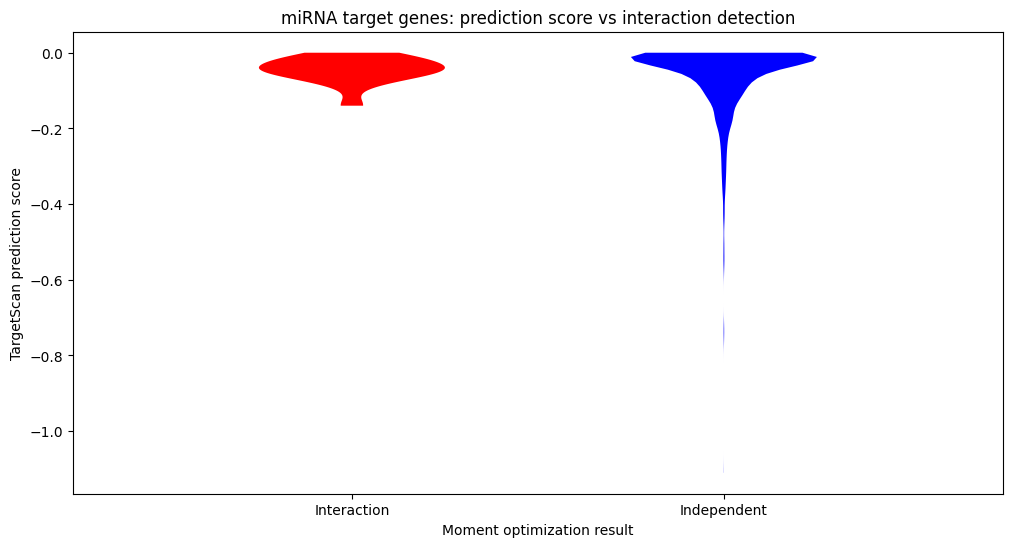

In [160]:
df = result_df[result_df['Target'] == True]
pos = df[df['Interaction'] == True]['Score'].to_list()
neg = df[df['Interaction'] == False]['Score'].to_list()

fig, axs = plt.subplots(figsize=(12, 6))
vp = axs.violinplot(
    [
        pos,
        neg
    ],
    showextrema=False
)
colours = ["red", "blue"]
for i, vi in enumerate(vp['bodies']):
    vi.set_facecolor(colours[i])
    vi.set_edgecolor(None)
    vi.set_alpha(1)
labels = ["Interaction", "Independent"]
axs.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
axs.set_xlim(0.25, len(labels) + 0.75)
axs.set_xlabel('Moment optimization result')
axs.set_ylabel("TargetScan prediction score")
axs.set_title("miRNA target genes: prediction score vs interaction detection")

In [161]:
tg = result_df[result_df['Target'] == True]['Interaction']
ntg = result_df[result_df['Target'] == False]['Interaction']

print(f"Target genes have {tg.mean() * 100}% interaction detected")
print(f"Non-Target genes have {ntg.mean() * 100}% interaction detected")

Target genes have 0.4987531172069825% interaction detected
Non-Target genes have 0.6047943699142292% interaction detected


Text(0.5, 0, 'Prediction score')

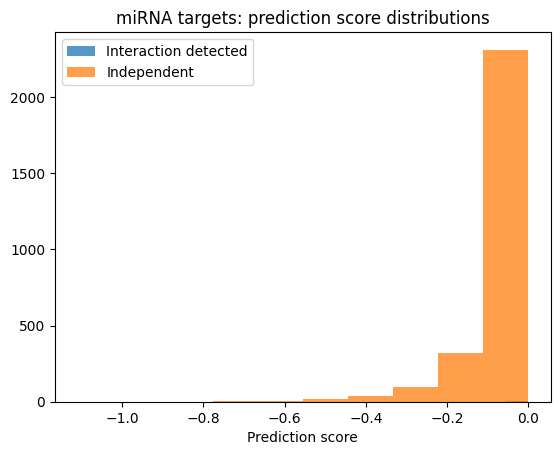

In [162]:
plt.hist(pos, label="Interaction detected", alpha=0.75)
plt.hist(neg, label="Independent", alpha=0.75)
plt.legend()
plt.title("miRNA targets: prediction score distributions")
plt.xlabel("Prediction score")